In [55]:
import datetime
from time import strftime
from calendar import monthrange
import operator
import sys

import pandas as pd
import pandas_datareader.data as datareader
import numpy as np

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV

import xgboost

import plotly as py
print (py.__version__) # requires version >= 1.9.0\n",
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.figure_factory as ff
init_notebook_mode(connected=True)

from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style('whitegrid')

random_state = 42
np.random.seed(random_state)



3.4.0


In [2]:
def convert_datestr(datestr):
    """Convert a beginning of month date string to end of month
    2018-01-01 -> 2018-01-31"""
    year_str, month_str, day_str = datestr.split('-')
    end_of_month = monthrange(int(year_str), int(month_str))[1]
    return "%s-%s-%02d" % (year_str, month_str, end_of_month)

def get_fred_data(series, start_date, end_date):
    retframe = datareader.DataReader(series, "fred", start_date, end_date)
    # convert dates from start to end of month and set index
    retframe['yyyymmdd'] = retframe.index.strftime('%Y-%m-%d')
    retframe['yyyymmdd'] = [convert_datestr(str) for str in retframe['yyyymmdd']]
    retframe['DATETIME'] = pd.to_datetime(retframe['yyyymmdd'])
    retframe.reset_index(inplace=True)
    return retframe[["DATETIME", series]]

start_date = datetime.datetime(1963, 1, 1)
end_date = datetime.datetime(2017, 12, 31)

TB3MS = get_fred_data("TB3MS", start_date, end_date)
TB3MS.head()

,DATETIME,TB3MS
0,1963-01-31,2.91
1,1963-02-28,2.92
2,1963-03-31,2.89
3,1963-04-30,2.90
4,1963-05-31,2.93


In [3]:
data = pd.read_pickle("data.pickle")
data.head()

,DATETIME,GVKEY,IND_CODE,VALUE,MOMENTUM,RET,RET3
1016,1963-01-31,1010,25,1.443624,0.126256,0.047002,0.077724
4326,1963-01-31,1040,6,0.448922,-0.477048,0.170732,0.041148
4620,1963-01-31,1043,41,0.255952,-0.390406,0.049505,-0.056931
5016,1963-01-31,1045,40,1.383475,-0.130926,0.102041,0.082269
8419,1963-01-31,1075,31,0.476919,-0.187948,0.060082,-0.002032


In [4]:
RF=TB3MS.copy()
RF["RF"]= RF["TB3MS"]/12/100
data.merge(RF[["DATETIME","RF"]], on="DATETIME").head()


,DATETIME,GVKEY,IND_CODE,VALUE,MOMENTUM,RET,RET3,RF
0,1963-01-31,1010,25,1.443624,0.126256,0.047002,0.077724,0.002425
1,1963-01-31,1040,6,0.448922,-0.477048,0.170732,0.041148,0.002425
2,1963-01-31,1043,41,0.255952,-0.390406,0.049505,-0.056931,0.002425
3,1963-01-31,1045,40,1.383475,-0.130926,0.102041,0.082269,0.002425
4,1963-01-31,1075,31,0.476919,-0.187948,0.060082,-0.002032,0.002425


In [5]:
uniquedates = sorted(data["DATETIME"].unique())
uniquedates[:10]


[numpy.datetime64('1963-01-31T00:00:00.000000000'),
 numpy.datetime64('1963-02-28T00:00:00.000000000'),
 numpy.datetime64('1963-03-31T00:00:00.000000000'),
 numpy.datetime64('1963-04-30T00:00:00.000000000'),
 numpy.datetime64('1963-05-31T00:00:00.000000000'),
 numpy.datetime64('1963-06-30T00:00:00.000000000'),
 numpy.datetime64('1963-07-31T00:00:00.000000000'),
 numpy.datetime64('1963-08-31T00:00:00.000000000'),
 numpy.datetime64('1963-09-30T00:00:00.000000000'),
 numpy.datetime64('1963-10-31T00:00:00.000000000')]

In [6]:
num_buckets = 5

def sharpe(ret, rf):
    "given monthly return, monthly risk-free return as series, return Sharpe"
    annvol = ret.std() * np.sqrt(12)
    excess_series = 1 + ret - rf
    # cumulative return at end of series
    excess = excess_series.cumprod().iloc[-1] 
    annexcess = excess ** (12/len(ret)) - 1
    sharpe = annexcess / annvol
    return sharpe

def bucket_df_by_col(df, col, num_buckets=num_buckets):
    # compute quantile buckets for df.col
    # assign new column col_RANK containing quantile bucket for each row
    newcol = col + "_RANK"
    # add a random small num to prevent bucket collisions
    df["tempcol"]=df[col] + np.random.uniform(0,0.0000001,len(df))
    # bucket tempcol into num_buckets quantiles
    vals = pd.qcut(df["tempcol"], num_buckets, labels=False)
    df[newcol] = vals
    #df = df.assign(c=col.values)
    return df

def perf_by_bucket(df, col, rank, perfcol="RET"):
    perf = df.loc[df[col]==rank][["DATETIME", col, perfcol]]\
        .groupby("DATETIME")\
        .mean()\
        .reset_index()
    return perf

def perf_bucket_by_col(data, col, nbuckets=5, rf=RF):

    col_rank = col + "_RANK"

    dflist = [bucket_df_by_col(data[data["DATETIME"]==d], col, nbuckets) for d in uniquedates]
    datanew= pd.concat(dflist)

    reportdict = {'Label': [],
                  'Annualized return' : [],
                  'Annualized volatility' : [],
                  'Sharpe': []}
    retdf = None
    for i in range(nbuckets):
        
        tempdf = perf_by_bucket(datanew, col_rank, i, perfcol="RET")
        # 1-month signal
        tempdf["RET1P"] = 1 + tempdf["RET"]
        tempdf["CUMPERF"] = tempdf["RET1P"].cumprod()
        tempdf["RF"] = rf["RF"]
        #display(tempdf)

        finalcumreturn = list(tempdf["CUMPERF"])[-1]
        annret = (finalcumreturn**(12/len(tempdf))-1)*100
        vol = tempdf["RET"].std() * np.sqrt(12) *100

        reportdict['Label'].append("Quintile %d " % (i))
        reportdict['Annualized return'].append(annret)
        reportdict['Annualized volatility'].append(vol)
        tempdf_sharpe = tempdf.dropna()
        reportdict['Sharpe'].append(sharpe(tempdf_sharpe["RET"], tempdf_sharpe["RF"]))
        
        tempdf.set_index("DATETIME", inplace=True)
        plt.semilogy(tempdf['CUMPERF'], label="Quintile %d (%.1f%% p.a.)" % (i, annret));
        
        if retdf is None:
            retdf = tempdf
        else:
            retdf = pd.concat([retdf, tempdf])
                 
    plt.legend();
    plt.title(col)
    plt.show()

    with pd.option_context('display.float_format', lambda x: "%.2f" % x):
        display(pd.DataFrame(reportdict))

    return retdf
  
  

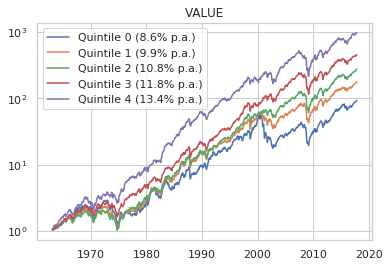

,Label,Annualized return,Annualized volatility,Sharpe
0,Quintile 0,8.62,20.45,0.18
1,Quintile 1,9.92,17.74,0.27
2,Quintile 2,10.80,16.45,0.35
3,Quintile 3,11.79,15.86,0.42
4,Quintile 4,13.37,16.43,0.50


,VALUE_RANK,RET,RET1P,CUMPERF,RF
DATETIME,,,,,
1963-01-31,0,0.048289,1.048289,1.048289,0.002425
1963-02-28,0,-0.026729,0.973271,1.020269,0.002433
1963-03-31,0,0.019942,1.019942,1.040615,0.002408
1963-04-30,0,0.037853,1.037853,1.080006,0.002417
1963-05-31,0,0.014698,1.014698,1.095880,0.002442


In [7]:
col = "VALUE"
value_returns = perf_bucket_by_col(data, col)
value_returns.head()

Accuracy: 0.210775


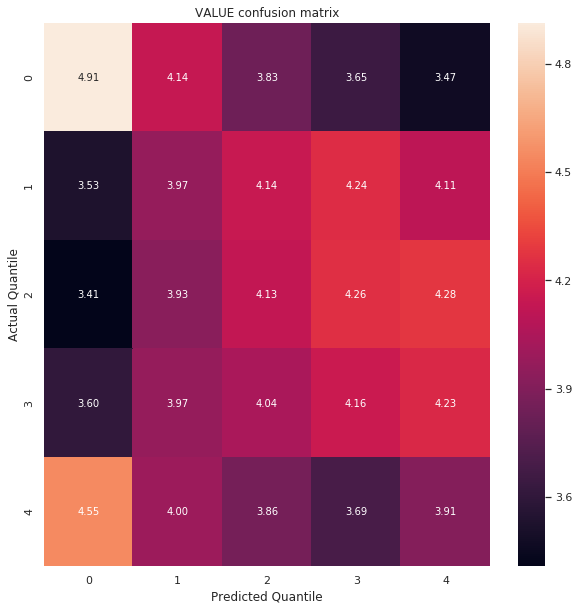

In [8]:
# compute accuracy, confusion_matrix

# compute rank for value and RET3
bucket_df_by_col(data, "VALUE")
bucket_df_by_col(data, "RET")

acc = accuracy_score(data["RET_RANK"], data["VALUE_RANK"])
print ("Accuracy: %0.6f" % acc)

def conf_matrix_heatmap(y_xval, y_xval_pred, title="Xval confusion matrix"):
    conf_matrix = confusion_matrix(y_xval, y_xval_pred)
    conf_matrix = conf_matrix / len(y_xval) * 100
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_matrix, annot=True, fmt='.02f')
    plt.ylabel('Actual Quantile')
    plt.xlabel('Predicted Quantile')
    plt.title(title)
    plt.show()

conf_matrix_heatmap(data["RET_RANK"], data["VALUE_RANK"], "VALUE confusion matrix")

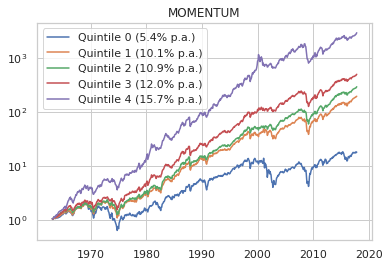

,Label,Annualized return,Annualized volatility,Sharpe
0,Quintile 0,5.42,21.74,0.02
1,Quintile 1,10.11,16.54,0.30
2,Quintile 2,10.93,15.18,0.38
3,Quintile 3,12.01,15.70,0.44
4,Quintile 4,15.69,20.08,0.52


,MOMENTUM_RANK,RET,RET1P,CUMPERF,RF
DATETIME,,,,,
1963-01-31,0,0.063590,1.063590,1.063590,0.002425
1963-02-28,0,-0.033680,0.966320,1.027768,0.002433
1963-03-31,0,0.011073,1.011073,1.039148,0.002408
1963-04-30,0,0.042294,1.042294,1.083099,0.002417
1963-05-31,0,0.019984,1.019984,1.104743,0.002442


In [9]:
col = "MOMENTUM"
momentum_returns = perf_bucket_by_col(data, col)
momentum_returns.head()

Accuracy: 0.236640


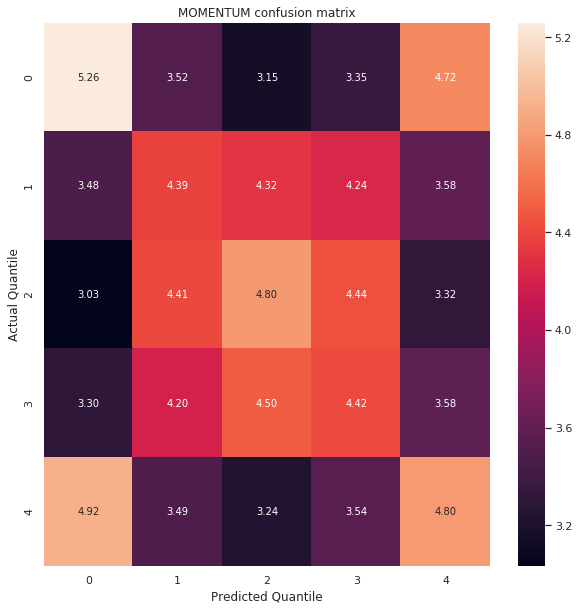

In [10]:
# prediction of RET3_RANK is MOMENTUM_RANK
# compute accuracy, confusion_matrix

# make sure you have good rank for momentum and RET3
bucket_df_by_col(data, "MOMENTUM")
bucket_df_by_col(data, "RET")

acc = accuracy_score(data["RET_RANK"], data["MOMENTUM_RANK"])
print ("Accuracy: %0.6f" % acc)

conf_matrix_heatmap(data["RET_RANK"], data["MOMENTUM_RANK"], "MOMENTUM confusion matrix")

In [35]:
data["VALUE_STD"]=StandardScaler().fit_transform(data["VALUE"].values.reshape(-1, 1))
data["MOMENTUM_STD"]=StandardScaler().fit_transform(data["MOMENTUM"].values.reshape(-1, 1))
data["COMBINED"] = data["VALUE_STD"] + data["MOMENTUM_STD"]
data.describe()


,GVKEY,IND_CODE,VALUE,MOMENTUM,RET,RET3,tempcol,VALUE_RANK,RET_RANK,MOMENTUM_RANK,FINANCIAL,RET3_RANK,VALUE_STD,MOMENTUM_STD,COMBINED
count,574590.000000,574590.000000,574590.000000,574590.000000,574590.000000,574590.000000,574590.000000,574590.000000,574590.000000,574590.000000,574590.000000,574590.000000,5.745900e+05,5.745900e+05,5.745900e+05
mean,20894.476696,29.731361,0.605870,0.190061,0.008487,0.029726,0.029726,2.000000,2.000000,2.000000,0.153268,2.000000,-2.897534e-14,-1.605252e-16,-3.161944e-15
std,38032.235507,12.694556,0.468992,0.422864,0.102417,0.179167,0.179167,1.414215,1.414215,1.414215,0.360246,1.414215,1.000001e+00,1.000001e+00,1.313518e+00
min,1004.000000,-1.000000,-0.942157,-0.989569,-0.981295,-0.997347,-0.997347,0.000000,0.000000,0.000000,0.000000,0.000000,-3.300759e+00,-2.789620e+00,-4.680397e+00
25%,4682.000000,21.000000,0.277153,-0.047228,-0.043860,-0.064766,-0.064766,1.000000,1.000000,1.000000,0.000000,1.000000,-7.009017e-01,-5.611468e-01,-8.566853e-01
50%,8215.000000,31.000000,0.493097,0.131425,0.007583,0.027362,0.027363,2.000000,2.000000,2.000000,0.000000,2.000000,-2.404596e-01,-1.386643e-01,-1.810856e-01
75%,12909.000000,41.000000,0.826458,0.342084,0.060000,0.120769,0.120769,3.000000,3.000000,3.000000,0.000000,3.000000,4.703449e-01,3.595076e-01,6.525748e-01
max,316056.000000,48.000000,3.996615,4.000000,3.001658,5.131941,5.131941,4.000000,4.000000,4.000000,1.000000,4.000000,7.229866e+00,9.009844e+00,1.392308e+01


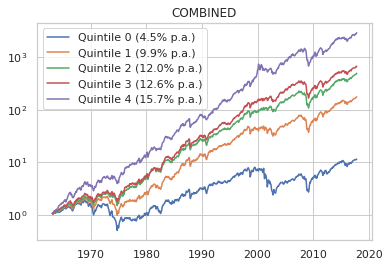

,Label,Annualized return,Annualized volatility,Sharpe
0,Quintile 0,4.53,20.63,-0.02
1,Quintile 1,9.89,16.89,0.29
2,Quintile 2,11.98,15.81,0.43
3,Quintile 3,12.62,15.62,0.48
4,Quintile 4,15.66,18.23,0.57


,VALUE_RANK,RET,RET1P,CUMPERF,RF
DATETIME,,,,,
1963-01-31,0,0.048289,1.048289,1.048289,0.002425
1963-02-28,0,-0.026729,0.973271,1.020269,0.002433
1963-03-31,0,0.019942,1.019942,1.040615,0.002408
1963-04-30,0,0.037853,1.037853,1.080006,0.002417
1963-05-31,0,0.014698,1.014698,1.095880,0.002442


In [36]:
col = "COMBINED"
combined_returns = perf_bucket_by_col(data, col)
value_returns.head()

Accuracy: 0.220375


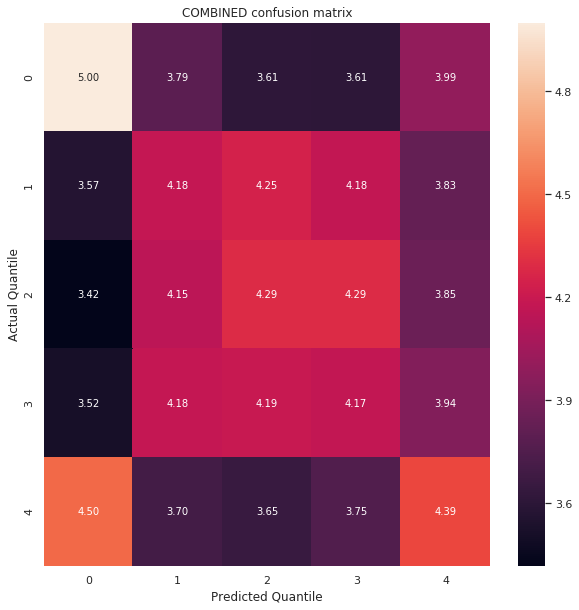

In [37]:
# prediction of RET3_RANK is COMBINED_RANK
# compute accuracy, confusion_matrix

# make sure you have good rank for COMBINED and RET3
bucket_df_by_col(data, "COMBINED")
bucket_df_by_col(data, "RET")

acc = accuracy_score(data["RET_RANK"], data["COMBINED_RANK"])
print ("Accuracy: %0.6f" % acc)

conf_matrix_heatmap(data["RET_RANK"], data["COMBINED_RANK"], "COMBINED confusion matrix")

In [11]:
# dummy variable for financials, enable model to treat them differently, e.g. p/b
data['FINANCIAL'] = 0
data.loc[data["IND_CODE"]==44,"FINANCIAL"] = 1
data.loc[data["IND_CODE"]==45,"FINANCIAL"] = 1
data.loc[data["IND_CODE"]==46,"FINANCIAL"] = 1
data.loc[data["IND_CODE"]==47,"FINANCIAL"] = 1

In [12]:
# make 3-month return quintile buckets
bucket_df_by_col(data, "RET3", num_buckets=num_buckets)
   
data.head()

,DATETIME,GVKEY,IND_CODE,VALUE,MOMENTUM,RET,RET3,tempcol,VALUE_RANK,RET_RANK,MOMENTUM_RANK,FINANCIAL,RET3_RANK
1016,1963-01-31,1010,25,1.443624,0.126256,0.047002,0.077724,0.077724,4,3,2,0,3
4326,1963-01-31,1040,6,0.448922,-0.477048,0.170732,0.041148,0.041148,2,4,0,0,2
4620,1963-01-31,1043,41,0.255952,-0.390406,0.049505,-0.056931,-0.056931,1,3,0,0,1
5016,1963-01-31,1045,40,1.383475,-0.130926,0.102041,0.082269,0.082269,4,4,0,0,3
8419,1963-01-31,1075,31,0.476919,-0.187948,0.060082,-0.002032,-0.002032,2,3,0,0,2


In [13]:
# make sure sorted by date, gvkey
data2 = data.sort_values(["DATETIME", "GVKEY"]) \
    .reset_index()\
    .reset_index()[["level_0","DATETIME","GVKEY","FINANCIAL","VALUE","MOMENTUM","RET","RET3_RANK","RET3"]]
data2.rename(index=str, columns={"level_0": "index"}, inplace=True)

# map dates to first row
dateindexes = data2.groupby(["DATETIME"])["index"].first()

P = np.zeros(len(data2))

In [25]:
for i in range(120, len(dateindexes)):
    
    daterange = dateindexes.index[0:i]
    print("fit from %s to %s" % (str(daterange[0]), str(daterange[-1])))
    fitrange = data2.iloc[0:dateindexes[i],:]
    print("fit from index %d to index %d" % (fitrange.iloc[0,:]["index"], fitrange.iloc[-1,:]["index"]))
    X = fitrange[["VALUE","MOMENTUM","FINANCIAL"]]
    y = fitrange["RET3_RANK"]
    
    model = LogisticRegression(multi_class='multinomial', 
                               solver='lbfgs', 
                               max_iter=10000,
                               n_jobs=-1)
    model.fit(X, y)
    
    print("predict %s" % (dateindexes.index[i]))
    if i+1 >= len(dateindexes): # last start date, predict from there to the end
        predrange = data2.iloc[dateindexes[i]:,:]
    else:
        predrange = data2.iloc[dateindexes[i]:dateindexes[i+1],:]
    print("predict from index %d to index %d" % (predrange.iloc[0,:]["index"], predrange.iloc[-1,:]["index"]))
    X_predict = predrange[["VALUE","MOMENTUM","FINANCIAL"]]
    y_predict = model.predict(X_predict)
    if i+1 >= len(dateindexes):
        P[dateindexes[i]:] = y_predict
    else:
        P[dateindexes[i]:dateindexes[i+1]] = y_predict

fit from 1963-01-31 00:00:00 to 1972-12-31 00:00:00
fit from index 0 to index 66483
predict 1973-01-31 00:00:00
predict from index 66484 to index 67220
fit from 1963-01-31 00:00:00 to 1973-01-31 00:00:00
fit from index 0 to index 67220
predict 1973-02-28 00:00:00
predict from index 67221 to index 67968
fit from 1963-01-31 00:00:00 to 1973-02-28 00:00:00
fit from index 0 to index 67968
predict 1973-03-31 00:00:00
predict from index 67969 to index 68694
fit from 1963-01-31 00:00:00 to 1973-03-31 00:00:00
fit from index 0 to index 68694
predict 1973-04-30 00:00:00
predict from index 68695 to index 69428
fit from 1963-01-31 00:00:00 to 1973-04-30 00:00:00
fit from index 0 to index 69428
predict 1973-05-31 00:00:00
predict from index 69429 to index 70168
fit from 1963-01-31 00:00:00 to 1973-05-31 00:00:00
fit from index 0 to index 70168
predict 1973-06-30 00:00:00
predict from index 70169 to index 70901
fit from 1963-01-31 00:00:00 to 1973-06-30 00:00:00
fit from index 0 to index 70901
pred

predict 1977-07-31 00:00:00
predict from index 110826 to index 111670
fit from 1963-01-31 00:00:00 to 1977-07-31 00:00:00
fit from index 0 to index 111670
predict 1977-08-31 00:00:00
predict from index 111671 to index 112507
fit from 1963-01-31 00:00:00 to 1977-08-31 00:00:00
fit from index 0 to index 112507
predict 1977-09-30 00:00:00
predict from index 112508 to index 113352
fit from 1963-01-31 00:00:00 to 1977-09-30 00:00:00
fit from index 0 to index 113352
predict 1977-10-31 00:00:00
predict from index 113353 to index 114206
fit from 1963-01-31 00:00:00 to 1977-10-31 00:00:00
fit from index 0 to index 114206
predict 1977-11-30 00:00:00
predict from index 114207 to index 115001
fit from 1963-01-31 00:00:00 to 1977-11-30 00:00:00
fit from index 0 to index 115001
predict 1977-12-31 00:00:00
predict from index 115002 to index 115821
fit from 1963-01-31 00:00:00 to 1977-12-31 00:00:00
fit from index 0 to index 115821
predict 1978-01-31 00:00:00
predict from index 115822 to index 116678


predict 1981-12-31 00:00:00
predict from index 154040 to index 154880
fit from 1963-01-31 00:00:00 to 1981-12-31 00:00:00
fit from index 0 to index 154880
predict 1982-01-31 00:00:00
predict from index 154881 to index 155739
fit from 1963-01-31 00:00:00 to 1982-01-31 00:00:00
fit from index 0 to index 155739
predict 1982-02-28 00:00:00
predict from index 155740 to index 156573
fit from 1963-01-31 00:00:00 to 1982-02-28 00:00:00
fit from index 0 to index 156573
predict 1982-03-31 00:00:00
predict from index 156574 to index 157385
fit from 1963-01-31 00:00:00 to 1982-03-31 00:00:00
fit from index 0 to index 157385
predict 1982-04-30 00:00:00
predict from index 157386 to index 158165
fit from 1963-01-31 00:00:00 to 1982-04-30 00:00:00
fit from index 0 to index 158165
predict 1982-05-31 00:00:00
predict from index 158166 to index 158986
fit from 1963-01-31 00:00:00 to 1982-05-31 00:00:00
fit from index 0 to index 158986
predict 1982-06-30 00:00:00
predict from index 158987 to index 159793


predict 1986-05-31 00:00:00
predict from index 196602 to index 197402
fit from 1963-01-31 00:00:00 to 1986-05-31 00:00:00
fit from index 0 to index 197402
predict 1986-06-30 00:00:00
predict from index 197403 to index 198236
fit from 1963-01-31 00:00:00 to 1986-06-30 00:00:00
fit from index 0 to index 198236
predict 1986-07-31 00:00:00
predict from index 198237 to index 199127
fit from 1963-01-31 00:00:00 to 1986-07-31 00:00:00
fit from index 0 to index 199127
predict 1986-08-31 00:00:00
predict from index 199128 to index 199938
fit from 1963-01-31 00:00:00 to 1986-08-31 00:00:00
fit from index 0 to index 199938
predict 1986-09-30 00:00:00
predict from index 199939 to index 200816
fit from 1963-01-31 00:00:00 to 1986-09-30 00:00:00
fit from index 0 to index 200816
predict 1986-10-31 00:00:00
predict from index 200817 to index 201650
fit from 1963-01-31 00:00:00 to 1986-10-31 00:00:00
fit from index 0 to index 201650
predict 1986-11-30 00:00:00
predict from index 201651 to index 202484


predict 1990-10-31 00:00:00
predict from index 240012 to index 240847
fit from 1963-01-31 00:00:00 to 1990-10-31 00:00:00
fit from index 0 to index 240847
predict 1990-11-30 00:00:00
predict from index 240848 to index 241637
fit from 1963-01-31 00:00:00 to 1990-11-30 00:00:00
fit from index 0 to index 241637
predict 1990-12-31 00:00:00
predict from index 241638 to index 242445
fit from 1963-01-31 00:00:00 to 1990-12-31 00:00:00
fit from index 0 to index 242445
predict 1991-01-31 00:00:00
predict from index 242446 to index 243257
fit from 1963-01-31 00:00:00 to 1991-01-31 00:00:00
fit from index 0 to index 243257
predict 1991-02-28 00:00:00
predict from index 243258 to index 244051
fit from 1963-01-31 00:00:00 to 1991-02-28 00:00:00
fit from index 0 to index 244051
predict 1991-03-31 00:00:00
predict from index 244052 to index 244874
fit from 1963-01-31 00:00:00 to 1991-03-31 00:00:00
fit from index 0 to index 244874
predict 1991-04-30 00:00:00
predict from index 244875 to index 245712


predict 1995-03-31 00:00:00
predict from index 288909 to index 289965
fit from 1963-01-31 00:00:00 to 1995-03-31 00:00:00
fit from index 0 to index 289965
predict 1995-04-30 00:00:00
predict from index 289966 to index 291052
fit from 1963-01-31 00:00:00 to 1995-04-30 00:00:00
fit from index 0 to index 291052
predict 1995-05-31 00:00:00
predict from index 291053 to index 292122
fit from 1963-01-31 00:00:00 to 1995-05-31 00:00:00
fit from index 0 to index 292122
predict 1995-06-30 00:00:00
predict from index 292123 to index 293184
fit from 1963-01-31 00:00:00 to 1995-06-30 00:00:00
fit from index 0 to index 293184
predict 1995-07-31 00:00:00
predict from index 293185 to index 294261
fit from 1963-01-31 00:00:00 to 1995-07-31 00:00:00
fit from index 0 to index 294261
predict 1995-08-31 00:00:00
predict from index 294262 to index 295361
fit from 1963-01-31 00:00:00 to 1995-08-31 00:00:00
fit from index 0 to index 295361
predict 1995-09-30 00:00:00
predict from index 295362 to index 296467


predict 1999-08-31 00:00:00
predict from index 351535 to index 352796
fit from 1963-01-31 00:00:00 to 1999-08-31 00:00:00
fit from index 0 to index 352796
predict 1999-09-30 00:00:00
predict from index 352797 to index 354028
fit from 1963-01-31 00:00:00 to 1999-09-30 00:00:00
fit from index 0 to index 354028
predict 1999-10-31 00:00:00
predict from index 354029 to index 355288
fit from 1963-01-31 00:00:00 to 1999-10-31 00:00:00
fit from index 0 to index 355288
predict 1999-11-30 00:00:00
predict from index 355289 to index 356523
fit from 1963-01-31 00:00:00 to 1999-11-30 00:00:00
fit from index 0 to index 356523
predict 1999-12-31 00:00:00
predict from index 356524 to index 357781
fit from 1963-01-31 00:00:00 to 1999-12-31 00:00:00
fit from index 0 to index 357781
predict 2000-01-31 00:00:00
predict from index 357782 to index 359099
fit from 1963-01-31 00:00:00 to 2000-01-31 00:00:00
fit from index 0 to index 359099
predict 2000-02-29 00:00:00
predict from index 359100 to index 360422


predict 2004-01-31 00:00:00
predict from index 410600 to index 411617
fit from 1963-01-31 00:00:00 to 2004-01-31 00:00:00
fit from index 0 to index 411617
predict 2004-02-29 00:00:00
predict from index 411618 to index 412632
fit from 1963-01-31 00:00:00 to 2004-02-29 00:00:00
fit from index 0 to index 412632
predict 2004-03-31 00:00:00
predict from index 412633 to index 413657
fit from 1963-01-31 00:00:00 to 2004-03-31 00:00:00
fit from index 0 to index 413657
predict 2004-04-30 00:00:00
predict from index 413658 to index 414691
fit from 1963-01-31 00:00:00 to 2004-04-30 00:00:00
fit from index 0 to index 414691
predict 2004-05-31 00:00:00
predict from index 414692 to index 415697
fit from 1963-01-31 00:00:00 to 2004-05-31 00:00:00
fit from index 0 to index 415697
predict 2004-06-30 00:00:00
predict from index 415698 to index 416675
fit from 1963-01-31 00:00:00 to 2004-06-30 00:00:00
fit from index 0 to index 416675
predict 2004-07-31 00:00:00
predict from index 416676 to index 417732


predict 2008-06-30 00:00:00
predict from index 462376 to index 463387
fit from 1963-01-31 00:00:00 to 2008-06-30 00:00:00
fit from index 0 to index 463387
predict 2008-07-31 00:00:00
predict from index 463388 to index 464344
fit from 1963-01-31 00:00:00 to 2008-07-31 00:00:00
fit from index 0 to index 464344
predict 2008-08-31 00:00:00
predict from index 464345 to index 465267
fit from 1963-01-31 00:00:00 to 2008-08-31 00:00:00
fit from index 0 to index 465267
predict 2008-09-30 00:00:00
predict from index 465268 to index 466268
fit from 1963-01-31 00:00:00 to 2008-09-30 00:00:00
fit from index 0 to index 466268
predict 2008-10-31 00:00:00
predict from index 466269 to index 467363
fit from 1963-01-31 00:00:00 to 2008-10-31 00:00:00
fit from index 0 to index 467363
predict 2008-11-30 00:00:00
predict from index 467364 to index 468394
fit from 1963-01-31 00:00:00 to 2008-11-30 00:00:00
fit from index 0 to index 468394
predict 2008-12-31 00:00:00
predict from index 468395 to index 469341


predict 2012-11-30 00:00:00
predict from index 513373 to index 514355
fit from 1963-01-31 00:00:00 to 2012-11-30 00:00:00
fit from index 0 to index 514355
predict 2012-12-31 00:00:00
predict from index 514356 to index 515326
fit from 1963-01-31 00:00:00 to 2012-12-31 00:00:00
fit from index 0 to index 515326
predict 2013-01-31 00:00:00
predict from index 515327 to index 516283
fit from 1963-01-31 00:00:00 to 2013-01-31 00:00:00
fit from index 0 to index 516283
predict 2013-02-28 00:00:00
predict from index 516284 to index 517268
fit from 1963-01-31 00:00:00 to 2013-02-28 00:00:00
fit from index 0 to index 517268
predict 2013-03-31 00:00:00
predict from index 517269 to index 518227
fit from 1963-01-31 00:00:00 to 2013-03-31 00:00:00
fit from index 0 to index 518227
predict 2013-04-30 00:00:00
predict from index 518228 to index 519206
fit from 1963-01-31 00:00:00 to 2013-04-30 00:00:00
fit from index 0 to index 519206
predict 2013-05-31 00:00:00
predict from index 519207 to index 520153


predict 2017-04-30 00:00:00
predict from index 567483 to index 568498
fit from 1963-01-31 00:00:00 to 2017-04-30 00:00:00
fit from index 0 to index 568498
predict 2017-05-31 00:00:00
predict from index 568499 to index 569526
fit from 1963-01-31 00:00:00 to 2017-05-31 00:00:00
fit from index 0 to index 569526
predict 2017-06-30 00:00:00
predict from index 569527 to index 570548
fit from 1963-01-31 00:00:00 to 2017-06-30 00:00:00
fit from index 0 to index 570548
predict 2017-07-31 00:00:00
predict from index 570549 to index 571564
fit from 1963-01-31 00:00:00 to 2017-07-31 00:00:00
fit from index 0 to index 571564
predict 2017-08-31 00:00:00
predict from index 571565 to index 572595
fit from 1963-01-31 00:00:00 to 2017-08-31 00:00:00
fit from index 0 to index 572595
predict 2017-09-30 00:00:00
predict from index 572596 to index 573585
fit from 1963-01-31 00:00:00 to 2017-09-30 00:00:00
fit from index 0 to index 573585
predict 2017-10-31 00:00:00
predict from index 573586 to index 574589


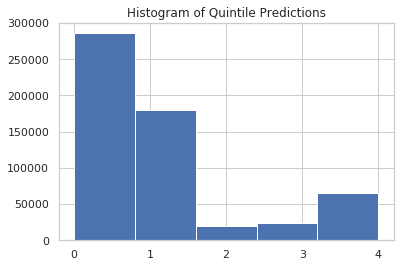

In [60]:

pd.DataFrame(P).hist(bins=5)
plt.xticks([0,1,2,3,4])
plt.title("Histogram of Quintile Predictions");

In [77]:
dateindexes[120:]

DATETIME
1973-01-31     66484
1973-02-28     67221
1973-03-31     67969
1973-04-30     68695
1973-05-31     69429
1973-06-30     70169
1973-07-31     70902
1973-08-31     71589
1973-09-30     72321
1973-10-31     73006
1973-11-30     73741
1973-12-31     74549
1974-01-31     75281
1974-02-28     76120
1974-03-31     76982
1974-04-30     77855
1974-05-31     78764
1974-06-30     79666
1974-07-31     80557
1974-08-31     81458
1974-09-30     82378
1974-10-31     83297
1974-11-30     84116
1974-12-31     85016
1975-01-31     85910
1975-02-28     86666
1975-03-31     87503
1975-04-30     88324
1975-05-31     89159
1975-06-30     89985
               ...  
2015-05-31    543367
2015-06-30    544402
2015-07-31    545462
2015-08-31    546563
2015-09-30    547674
2015-10-31    548787
2015-11-30    549823
2015-12-31    550879
2016-01-31    551985
2016-02-29    553113
2016-03-31    554172
2016-04-30    555173
2016-05-31    556194
2016-06-30    557218
2016-07-31    558267
2016-08-31    559285
2016

In [79]:
data2["PREDRANK"] = P  
data3 = data2.copy()
data3 = data3.iloc[dateindexes[120]:,:]
data3.head()

,index,DATETIME,GVKEY,FINANCIAL,VALUE,MOMENTUM,RET,RET3_RANK,RET3,P,PREDRANK
66484,66484,1973-01-31,1010,0,1.044125,-0.010382,-0.060367,1,-0.035879,1.0,1.0
66485,66485,1973-01-31,1040,0,0.215630,0.147918,-0.336343,0,-0.426136,1.0,1.0
66486,66486,1973-01-31,1043,0,0.600845,0.125996,-0.166667,0,-0.381818,1.0,1.0
66487,66487,1973-01-31,1045,0,0.835086,-0.331288,-0.223881,0,-0.194030,1.0,1.0
66488,66488,1973-01-31,1075,0,1.047037,0.246193,-0.040000,0,-0.129671,1.0,1.0


In [80]:
data3.to_pickle('bad_lr_classification_predict_buckets.pickle')
data3.head()

,index,DATETIME,GVKEY,FINANCIAL,VALUE,MOMENTUM,RET,RET3_RANK,RET3,P,PREDRANK
66484,66484,1973-01-31,1010,0,1.044125,-0.010382,-0.060367,1,-0.035879,1.0,1.0
66485,66485,1973-01-31,1040,0,0.215630,0.147918,-0.336343,0,-0.426136,1.0,1.0
66486,66486,1973-01-31,1043,0,0.600845,0.125996,-0.166667,0,-0.381818,1.0,1.0
66487,66487,1973-01-31,1045,0,0.835086,-0.331288,-0.223881,0,-0.194030,1.0,1.0
66488,66488,1973-01-31,1075,0,1.047037,0.246193,-0.040000,0,-0.129671,1.0,1.0


In [81]:
# we predicted 3-month return buckets
# for all the 1s, we will collect this month's return + next 2 months, to hold for 3 months [datetime, gvkey, return, monthno]

# for now, store the DATES values as extra columns in data3
data3=pd.read_pickle('bad_lr_classification_predict_buckets.pickle')
# create dataframe of all the dates
dates_df = pd.DataFrame(dateindexes)
dates_df["t0"]=dates_df.index
dates_df["t1"]=dates_df.shift(-1)["t0"]
dates_df["t2"]=dates_df.shift(-2)["t0"]

In [82]:
dates_df.head()

,index,t0,t1,t2
DATETIME,,,,
1963-01-31,0,1963-01-31,1963-02-28,1963-03-31
1963-02-28,402,1963-02-28,1963-03-31,1963-04-30
1963-03-31,818,1963-03-31,1963-04-30,1963-05-31
1963-04-30,1228,1963-04-30,1963-05-31,1963-06-30
1963-05-31,1637,1963-05-31,1963-06-30,1963-07-31


In [83]:
# store t+1 and t+2 in data3
data3["DATETIME1"] = dates_df.loc[data3["DATETIME"]]["t1"].values
data3["DATETIME2"] = dates_df.loc[data3["DATETIME"]]["t2"].values

In [84]:
display(data3.head())
display(data3.tail())

,index,DATETIME,GVKEY,FINANCIAL,VALUE,MOMENTUM,RET,RET3_RANK,RET3,P,PREDRANK,DATETIME1,DATETIME2
66484,66484,1973-01-31,1010,0,1.044125,-0.010382,-0.060367,1,-0.035879,1.0,1.0,1973-02-28,1973-03-31
66485,66485,1973-01-31,1040,0,0.215630,0.147918,-0.336343,0,-0.426136,1.0,1.0,1973-02-28,1973-03-31
66486,66486,1973-01-31,1043,0,0.600845,0.125996,-0.166667,0,-0.381818,1.0,1.0,1973-02-28,1973-03-31
66487,66487,1973-01-31,1045,0,0.835086,-0.331288,-0.223881,0,-0.194030,1.0,1.0,1973-02-28,1973-03-31
66488,66488,1973-01-31,1075,0,1.047037,0.246193,-0.040000,0,-0.129671,1.0,1.0,1973-02-28,1973-03-31


,index,DATETIME,GVKEY,FINANCIAL,VALUE,MOMENTUM,RET,RET3_RANK,RET3,P,PREDRANK,DATETIME1,DATETIME2
574585,574585,2017-10-31,293884,0,0.181239,0.431529,0.048302,4,0.157079,0.0,0.0,NaT,NaT
574586,574586,2017-10-31,294524,0,0.246494,0.156449,0.045230,3,0.122867,0.0,0.0,NaT,NaT
574587,574587,2017-10-31,295786,0,0.291927,0.590161,0.057452,3,0.115736,0.0,0.0,NaT,NaT
574588,574588,2017-10-31,315318,0,0.936775,0.440197,-0.040359,0,-0.110314,4.0,4.0,NaT,NaT
574589,574589,2017-10-31,316056,1,0.014658,0.149037,-0.035619,1,-0.078062,0.0,0.0,NaT,NaT


In [85]:
data3['PREDRANK']=data3['P']
data3.head()

,index,DATETIME,GVKEY,FINANCIAL,VALUE,MOMENTUM,RET,RET3_RANK,RET3,P,PREDRANK,DATETIME1,DATETIME2
66484,66484,1973-01-31,1010,0,1.044125,-0.010382,-0.060367,1,-0.035879,1.0,1.0,1973-02-28,1973-03-31
66485,66485,1973-01-31,1040,0,0.215630,0.147918,-0.336343,0,-0.426136,1.0,1.0,1973-02-28,1973-03-31
66486,66486,1973-01-31,1043,0,0.600845,0.125996,-0.166667,0,-0.381818,1.0,1.0,1973-02-28,1973-03-31
66487,66487,1973-01-31,1045,0,0.835086,-0.331288,-0.223881,0,-0.194030,1.0,1.0,1973-02-28,1973-03-31
66488,66488,1973-01-31,1075,0,1.047037,0.246193,-0.040000,0,-0.129671,1.0,1.0,1973-02-28,1973-03-31


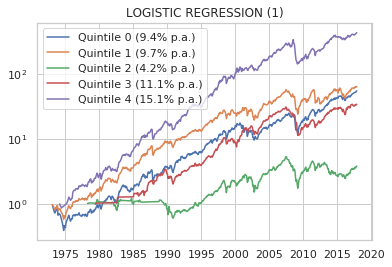

,Label,Annualized return,Annualized volatility,Sharpe
0,Quintile 0,9.36,18.66,0.18
1,Quintile 1,9.73,18.19,0.20
2,Quintile 2,4.18,20.33,-0.11
3,Quintile 3,11.06,17.59,0.24
4,Quintile 4,15.10,17.41,0.50


In [86]:

reportdict = {'Label': [],
              'Annualized return' : [],
              'Annualized volatility' : [],
              'Sharpe': []}

for i in range(num_buckets):

    # get returns for this bucket
    T0 = data3.loc[data3["PREDRANK"]==i]
    # get returns for t+1
    # inner join, note some stocks will not have returns for t+1
    # corp action or possibly also excluded by mkt cap filter
    T1 = T0[["DATETIME1", "GVKEY"]].merge(data3, how='left',
                                          left_on=["DATETIME1", "GVKEY"], 
                                          right_on=["DATETIME", "GVKEY"])[["DATETIME", "GVKEY", "RET"]]
    T2 = T0[["DATETIME2", "GVKEY"]].merge(data3, how='left',
                                          left_on=["DATETIME2", "GVKEY"], 
                                          right_on=["DATETIME", "GVKEY"])[["DATETIME", "GVKEY", "RET"]]
    T2.sort_values(['DATETIME', 'GVKEY']).tail()
    
    G0 = T0[["DATETIME","RET"]].groupby("DATETIME").mean()
    G1 = T1[["DATETIME","RET"]].groupby("DATETIME").mean()
    G2 = T2[["DATETIME","RET"]].groupby("DATETIME").mean()
    G_all = pd.merge(G1,G2,on="DATETIME", how="outer", suffixes=["1", "2"])
    G_all = pd.merge(G_all,G0,on="DATETIME", how="outer") \
        .sort_values("DATETIME") \
        .reset_index() 
    # average returns by month
    G_all = G_all.fillna(value=0) # otherwise only 1/3 of portfolio at work 1st month + 2 NAs = NA
    G_all["RET"] = (G_all["RET"] + G_all["RET1"] + G_all["RET2"]) /3
    
    # compute cumulative return
    tempdf = pd.DataFrame(G_all[["DATETIME", "RET"]])

    tempdf["RET1P"] = 1 + tempdf["RET"]
    tempdf["CUMPERF"] = tempdf["RET1P"].cumprod()
    tempdf.reset_index(inplace=True)
    tempdf["RF"] = RF["RF"]

    lastval = list(tempdf["CUMPERF"])[-1]
    annret = (lastval**(12/len(tempdf))-1)*100
    vol = tempdf["CUMPERF"].pct_change().std() * np.sqrt(12) * 100

    reportdict['Label'].append("Quintile %d " % (i))
    reportdict['Annualized return'].append(annret)
    reportdict['Annualized volatility'].append(vol)
    tempdf_sharpe = tempdf.dropna()
    reportdict['Sharpe'].append(sharpe(tempdf_sharpe["RET"], tempdf_sharpe["RF"]))

    tempdf.set_index("DATETIME", inplace=True)
    plt.semilogy(tempdf['CUMPERF'], label="Quintile %d (%.1f%% p.a.)" % (i, annret));

plt.legend();
plt.title("LOGISTIC REGRESSION (1)")
plt.show()

with pd.option_context('display.float_format', lambda x: "%.2f" % x):
    display(pd.DataFrame(reportdict))
    

In [14]:
# run classification backtest 

# make sure sorted by date, gvkey
data2 = data.sort_values(["DATETIME", "GVKEY"]) \
    .reset_index()\
    .reset_index()[["level_0","DATETIME","GVKEY","FINANCIAL","VALUE","MOMENTUM","RET","RET3_RANK","RET3"]]
data2.rename(index=str, columns={"level_0": "index"}, inplace=True)

# map dates to first row
dateindexes = data2.groupby(["DATETIME"])["index"].first()

P = np.zeros(len(data2))

In [15]:
for i in range(120, len(dateindexes)):
    
    daterange = dateindexes.index[0:i]
    print("fit from %s to %s" % (str(daterange[0]), str(daterange[-1])))
    fitrange = data2.iloc[0:dateindexes[i],:]
    print("fit from index %d to index %d" % (fitrange.iloc[0,:]["index"], fitrange.iloc[-1,:]["index"]))
    X = fitrange[["VALUE","MOMENTUM","FINANCIAL"]]
    y = fitrange["RET3_RANK"]
    
    model = LogisticRegression(multi_class='multinomial', 
                               solver='lbfgs', 
                               max_iter=10000,
                               n_jobs=-1)
    model.fit(X, y)
    
    print("predict %s" % (dateindexes.index[i]))
    if i+1 >= len(dateindexes): # last start date, predict from there to the end
        predrange = data2.iloc[dateindexes[i]:,:]
    else:
        predrange = data2.iloc[dateindexes[i]:dateindexes[i+1],:]
    print("predict from index %d to index %d" % (predrange.iloc[0,:]["index"], predrange.iloc[-1,:]["index"]))
    X_predict = predrange[["VALUE","MOMENTUM","FINANCIAL"]]
    y_predict_proba = model.predict_proba(X_predict)
    # weighted average 
    y_predict = y_predict_proba.dot(np.matrix("0 ; 1; 2; 3; 4"))
    if i+1 >= len(dateindexes):
        P[dateindexes[i]:] = y_predict.reshape(y_predict.shape[0])
    else:
        P[dateindexes[i]:dateindexes[i+1]] = y_predict.reshape(y_predict.shape[0])

fit from 1963-01-31 00:00:00 to 1972-12-31 00:00:00
fit from index 0 to index 66483
predict 1973-01-31 00:00:00
predict from index 66484 to index 67220
fit from 1963-01-31 00:00:00 to 1973-01-31 00:00:00
fit from index 0 to index 67220
predict 1973-02-28 00:00:00
predict from index 67221 to index 67968
fit from 1963-01-31 00:00:00 to 1973-02-28 00:00:00
fit from index 0 to index 67968
predict 1973-03-31 00:00:00
predict from index 67969 to index 68694
fit from 1963-01-31 00:00:00 to 1973-03-31 00:00:00
fit from index 0 to index 68694
predict 1973-04-30 00:00:00
predict from index 68695 to index 69428
fit from 1963-01-31 00:00:00 to 1973-04-30 00:00:00
fit from index 0 to index 69428
predict 1973-05-31 00:00:00
predict from index 69429 to index 70168
fit from 1963-01-31 00:00:00 to 1973-05-31 00:00:00
fit from index 0 to index 70168
predict 1973-06-30 00:00:00
predict from index 70169 to index 70901
fit from 1963-01-31 00:00:00 to 1973-06-30 00:00:00
fit from index 0 to index 70901
pred

predict 1977-07-31 00:00:00
predict from index 110826 to index 111670
fit from 1963-01-31 00:00:00 to 1977-07-31 00:00:00
fit from index 0 to index 111670
predict 1977-08-31 00:00:00
predict from index 111671 to index 112507
fit from 1963-01-31 00:00:00 to 1977-08-31 00:00:00
fit from index 0 to index 112507
predict 1977-09-30 00:00:00
predict from index 112508 to index 113352
fit from 1963-01-31 00:00:00 to 1977-09-30 00:00:00
fit from index 0 to index 113352
predict 1977-10-31 00:00:00
predict from index 113353 to index 114206
fit from 1963-01-31 00:00:00 to 1977-10-31 00:00:00
fit from index 0 to index 114206
predict 1977-11-30 00:00:00
predict from index 114207 to index 115001
fit from 1963-01-31 00:00:00 to 1977-11-30 00:00:00
fit from index 0 to index 115001
predict 1977-12-31 00:00:00
predict from index 115002 to index 115821
fit from 1963-01-31 00:00:00 to 1977-12-31 00:00:00
fit from index 0 to index 115821
predict 1978-01-31 00:00:00
predict from index 115822 to index 116678


predict 1981-12-31 00:00:00
predict from index 154040 to index 154880
fit from 1963-01-31 00:00:00 to 1981-12-31 00:00:00
fit from index 0 to index 154880
predict 1982-01-31 00:00:00
predict from index 154881 to index 155739
fit from 1963-01-31 00:00:00 to 1982-01-31 00:00:00
fit from index 0 to index 155739
predict 1982-02-28 00:00:00
predict from index 155740 to index 156573
fit from 1963-01-31 00:00:00 to 1982-02-28 00:00:00
fit from index 0 to index 156573
predict 1982-03-31 00:00:00
predict from index 156574 to index 157385
fit from 1963-01-31 00:00:00 to 1982-03-31 00:00:00
fit from index 0 to index 157385
predict 1982-04-30 00:00:00
predict from index 157386 to index 158165
fit from 1963-01-31 00:00:00 to 1982-04-30 00:00:00
fit from index 0 to index 158165
predict 1982-05-31 00:00:00
predict from index 158166 to index 158986
fit from 1963-01-31 00:00:00 to 1982-05-31 00:00:00
fit from index 0 to index 158986
predict 1982-06-30 00:00:00
predict from index 158987 to index 159793


predict 1986-05-31 00:00:00
predict from index 196602 to index 197402
fit from 1963-01-31 00:00:00 to 1986-05-31 00:00:00
fit from index 0 to index 197402
predict 1986-06-30 00:00:00
predict from index 197403 to index 198236
fit from 1963-01-31 00:00:00 to 1986-06-30 00:00:00
fit from index 0 to index 198236
predict 1986-07-31 00:00:00
predict from index 198237 to index 199127
fit from 1963-01-31 00:00:00 to 1986-07-31 00:00:00
fit from index 0 to index 199127
predict 1986-08-31 00:00:00
predict from index 199128 to index 199938
fit from 1963-01-31 00:00:00 to 1986-08-31 00:00:00
fit from index 0 to index 199938
predict 1986-09-30 00:00:00
predict from index 199939 to index 200816
fit from 1963-01-31 00:00:00 to 1986-09-30 00:00:00
fit from index 0 to index 200816
predict 1986-10-31 00:00:00
predict from index 200817 to index 201650
fit from 1963-01-31 00:00:00 to 1986-10-31 00:00:00
fit from index 0 to index 201650
predict 1986-11-30 00:00:00
predict from index 201651 to index 202484


predict 1990-10-31 00:00:00
predict from index 240012 to index 240847
fit from 1963-01-31 00:00:00 to 1990-10-31 00:00:00
fit from index 0 to index 240847
predict 1990-11-30 00:00:00
predict from index 240848 to index 241637
fit from 1963-01-31 00:00:00 to 1990-11-30 00:00:00
fit from index 0 to index 241637
predict 1990-12-31 00:00:00
predict from index 241638 to index 242445
fit from 1963-01-31 00:00:00 to 1990-12-31 00:00:00
fit from index 0 to index 242445
predict 1991-01-31 00:00:00
predict from index 242446 to index 243257
fit from 1963-01-31 00:00:00 to 1991-01-31 00:00:00
fit from index 0 to index 243257
predict 1991-02-28 00:00:00
predict from index 243258 to index 244051
fit from 1963-01-31 00:00:00 to 1991-02-28 00:00:00
fit from index 0 to index 244051
predict 1991-03-31 00:00:00
predict from index 244052 to index 244874
fit from 1963-01-31 00:00:00 to 1991-03-31 00:00:00
fit from index 0 to index 244874
predict 1991-04-30 00:00:00
predict from index 244875 to index 245712


predict 1995-03-31 00:00:00
predict from index 288909 to index 289965
fit from 1963-01-31 00:00:00 to 1995-03-31 00:00:00
fit from index 0 to index 289965
predict 1995-04-30 00:00:00
predict from index 289966 to index 291052
fit from 1963-01-31 00:00:00 to 1995-04-30 00:00:00
fit from index 0 to index 291052
predict 1995-05-31 00:00:00
predict from index 291053 to index 292122
fit from 1963-01-31 00:00:00 to 1995-05-31 00:00:00
fit from index 0 to index 292122
predict 1995-06-30 00:00:00
predict from index 292123 to index 293184
fit from 1963-01-31 00:00:00 to 1995-06-30 00:00:00
fit from index 0 to index 293184
predict 1995-07-31 00:00:00
predict from index 293185 to index 294261
fit from 1963-01-31 00:00:00 to 1995-07-31 00:00:00
fit from index 0 to index 294261
predict 1995-08-31 00:00:00
predict from index 294262 to index 295361
fit from 1963-01-31 00:00:00 to 1995-08-31 00:00:00
fit from index 0 to index 295361
predict 1995-09-30 00:00:00
predict from index 295362 to index 296467


predict 1999-08-31 00:00:00
predict from index 351535 to index 352796
fit from 1963-01-31 00:00:00 to 1999-08-31 00:00:00
fit from index 0 to index 352796
predict 1999-09-30 00:00:00
predict from index 352797 to index 354028
fit from 1963-01-31 00:00:00 to 1999-09-30 00:00:00
fit from index 0 to index 354028
predict 1999-10-31 00:00:00
predict from index 354029 to index 355288
fit from 1963-01-31 00:00:00 to 1999-10-31 00:00:00
fit from index 0 to index 355288
predict 1999-11-30 00:00:00
predict from index 355289 to index 356523
fit from 1963-01-31 00:00:00 to 1999-11-30 00:00:00
fit from index 0 to index 356523
predict 1999-12-31 00:00:00
predict from index 356524 to index 357781
fit from 1963-01-31 00:00:00 to 1999-12-31 00:00:00
fit from index 0 to index 357781
predict 2000-01-31 00:00:00
predict from index 357782 to index 359099
fit from 1963-01-31 00:00:00 to 2000-01-31 00:00:00
fit from index 0 to index 359099
predict 2000-02-29 00:00:00
predict from index 359100 to index 360422


predict 2004-01-31 00:00:00
predict from index 410600 to index 411617
fit from 1963-01-31 00:00:00 to 2004-01-31 00:00:00
fit from index 0 to index 411617
predict 2004-02-29 00:00:00
predict from index 411618 to index 412632
fit from 1963-01-31 00:00:00 to 2004-02-29 00:00:00
fit from index 0 to index 412632
predict 2004-03-31 00:00:00
predict from index 412633 to index 413657
fit from 1963-01-31 00:00:00 to 2004-03-31 00:00:00
fit from index 0 to index 413657
predict 2004-04-30 00:00:00
predict from index 413658 to index 414691
fit from 1963-01-31 00:00:00 to 2004-04-30 00:00:00
fit from index 0 to index 414691
predict 2004-05-31 00:00:00
predict from index 414692 to index 415697
fit from 1963-01-31 00:00:00 to 2004-05-31 00:00:00
fit from index 0 to index 415697
predict 2004-06-30 00:00:00
predict from index 415698 to index 416675
fit from 1963-01-31 00:00:00 to 2004-06-30 00:00:00
fit from index 0 to index 416675
predict 2004-07-31 00:00:00
predict from index 416676 to index 417732


predict 2008-06-30 00:00:00
predict from index 462376 to index 463387
fit from 1963-01-31 00:00:00 to 2008-06-30 00:00:00
fit from index 0 to index 463387
predict 2008-07-31 00:00:00
predict from index 463388 to index 464344
fit from 1963-01-31 00:00:00 to 2008-07-31 00:00:00
fit from index 0 to index 464344
predict 2008-08-31 00:00:00
predict from index 464345 to index 465267
fit from 1963-01-31 00:00:00 to 2008-08-31 00:00:00
fit from index 0 to index 465267
predict 2008-09-30 00:00:00
predict from index 465268 to index 466268
fit from 1963-01-31 00:00:00 to 2008-09-30 00:00:00
fit from index 0 to index 466268
predict 2008-10-31 00:00:00
predict from index 466269 to index 467363
fit from 1963-01-31 00:00:00 to 2008-10-31 00:00:00
fit from index 0 to index 467363
predict 2008-11-30 00:00:00
predict from index 467364 to index 468394
fit from 1963-01-31 00:00:00 to 2008-11-30 00:00:00
fit from index 0 to index 468394
predict 2008-12-31 00:00:00
predict from index 468395 to index 469341


predict 2012-11-30 00:00:00
predict from index 513373 to index 514355
fit from 1963-01-31 00:00:00 to 2012-11-30 00:00:00
fit from index 0 to index 514355
predict 2012-12-31 00:00:00
predict from index 514356 to index 515326
fit from 1963-01-31 00:00:00 to 2012-12-31 00:00:00
fit from index 0 to index 515326
predict 2013-01-31 00:00:00
predict from index 515327 to index 516283
fit from 1963-01-31 00:00:00 to 2013-01-31 00:00:00
fit from index 0 to index 516283
predict 2013-02-28 00:00:00
predict from index 516284 to index 517268
fit from 1963-01-31 00:00:00 to 2013-02-28 00:00:00
fit from index 0 to index 517268
predict 2013-03-31 00:00:00
predict from index 517269 to index 518227
fit from 1963-01-31 00:00:00 to 2013-03-31 00:00:00
fit from index 0 to index 518227
predict 2013-04-30 00:00:00
predict from index 518228 to index 519206
fit from 1963-01-31 00:00:00 to 2013-04-30 00:00:00
fit from index 0 to index 519206
predict 2013-05-31 00:00:00
predict from index 519207 to index 520153


predict 2017-04-30 00:00:00
predict from index 567483 to index 568498
fit from 1963-01-31 00:00:00 to 2017-04-30 00:00:00
fit from index 0 to index 568498
predict 2017-05-31 00:00:00
predict from index 568499 to index 569526
fit from 1963-01-31 00:00:00 to 2017-05-31 00:00:00
fit from index 0 to index 569526
predict 2017-06-30 00:00:00
predict from index 569527 to index 570548
fit from 1963-01-31 00:00:00 to 2017-06-30 00:00:00
fit from index 0 to index 570548
predict 2017-07-31 00:00:00
predict from index 570549 to index 571564
fit from 1963-01-31 00:00:00 to 2017-07-31 00:00:00
fit from index 0 to index 571564
predict 2017-08-31 00:00:00
predict from index 571565 to index 572595
fit from 1963-01-31 00:00:00 to 2017-08-31 00:00:00
fit from index 0 to index 572595
predict 2017-09-30 00:00:00
predict from index 572596 to index 573585
fit from 1963-01-31 00:00:00 to 2017-09-30 00:00:00
fit from index 0 to index 573585
predict 2017-10-31 00:00:00
predict from index 573586 to index 574589


In [17]:
# we now have forecasts for full period
# bucket forecasts

# put P forecast into data2
data2["P"] = P  

# bucket predictions, put into PREDRANK
data3 = None
for d in dateindexes.index[120:]:
    tempdf = data2.loc[data2["DATETIME"]==d]
    print(d, len(tempdf))
    tempdf["PREDRANK"] = pd.qcut(tempdf["P"], num_buckets, labels=False)
    if data3 is None:
        data3 = tempdf
    else:
        data3 = pd.concat([data3, tempdf])

1973-01-31 00:00:00 737
1973-02-28 00:00:00 748
1973-03-31 00:00:00 726
1973-04-30 00:00:00 734
1973-05-31 00:00:00 740
1973-06-30 00:00:00 733
1973-07-31 00:00:00 687
1973-08-31 00:00:00 732
1973-09-30 00:00:00 685
1973-10-31 00:00:00 735
1973-11-30 00:00:00 808
1973-12-31 00:00:00 732
1974-01-31 00:00:00 839
1974-02-28 00:00:00 862
1974-03-31 00:00:00 873
1974-04-30 00:00:00 909
1974-05-31 00:00:00 902
1974-06-30 00:00:00 891
1974-07-31 00:00:00 901
1974-08-31 00:00:00 920
1974-09-30 00:00:00 919
1974-10-31 00:00:00 819
1974-11-30 00:00:00 900
1974-12-31 00:00:00 894
1975-01-31 00:00:00 756
1975-02-28 00:00:00 837
1975-03-31 00:00:00 821
1975-04-30 00:00:00 835
1975-05-31 00:00:00 826
1975-06-30 00:00:00 809
1975-07-31 00:00:00 873
1975-08-31 00:00:00 861
1975-09-30 00:00:00 866
1975-10-31 00:00:00 840
1975-11-30 00:00:00 829
1975-12-31 00:00:00 846
1976-01-31 00:00:00 779
1976-02-29 00:00:00 823
1976-03-31 00:00:00 833
1976-04-30 00:00:00 842
1976-05-31 00:00:00 849
1976-06-30 00:00

2001-08-31 00:00:00 1109
2001-09-30 00:00:00 1190
2001-10-31 00:00:00 1020
2001-11-30 00:00:00 1018
2001-12-31 00:00:00 1053
2002-01-31 00:00:00 1097
2002-02-28 00:00:00 1047
2002-03-31 00:00:00 997
2002-04-30 00:00:00 1027
2002-05-31 00:00:00 1038
2002-06-30 00:00:00 1047
2002-07-31 00:00:00 1095
2002-08-31 00:00:00 1005
2002-09-30 00:00:00 1081
2002-10-31 00:00:00 992
2002-11-30 00:00:00 982
2002-12-31 00:00:00 1052
2003-01-31 00:00:00 1035
2003-02-28 00:00:00 1039
2003-03-31 00:00:00 1016
2003-04-30 00:00:00 964
2003-05-31 00:00:00 978
2003-06-30 00:00:00 1013
2003-07-31 00:00:00 1005
2003-08-31 00:00:00 1015
2003-09-30 00:00:00 1026
2003-10-31 00:00:00 989
2003-11-30 00:00:00 1022
2003-12-31 00:00:00 1009
2004-01-31 00:00:00 1018
2004-02-29 00:00:00 1015
2004-03-31 00:00:00 1025
2004-04-30 00:00:00 1034
2004-05-31 00:00:00 1006
2004-06-30 00:00:00 978
2004-07-31 00:00:00 1057
2004-08-31 00:00:00 1005
2004-09-30 00:00:00 981
2004-10-31 00:00:00 986
2004-11-30 00:00:00 943
2004-12-31

In [18]:
data3.to_pickle('lr_classification_predict_buckets.pickle')
data3.head()

,index,DATETIME,GVKEY,FINANCIAL,VALUE,MOMENTUM,RET,RET3_RANK,RET3,P,PREDRANK
66484,66484,1973-01-31,1010,0,1.044125,-0.010382,-0.060367,1,-0.035879,1.992718,4
66485,66485,1973-01-31,1040,0,0.215630,0.147918,-0.336343,0,-0.426136,1.878088,0
66486,66486,1973-01-31,1043,0,0.600845,0.125996,-0.166667,0,-0.381818,1.933058,2
66487,66487,1973-01-31,1045,0,0.835086,-0.331288,-0.223881,0,-0.194030,1.963076,3
66488,66488,1973-01-31,1075,0,1.047037,0.246193,-0.040000,0,-0.129671,1.995301,4


In [88]:
# we predicted 3-month returns
# for all the 1s, we will collect this month's return + next 2 months, to hold for 3 months [datetime, gvkey, return, monthno]

# for now, store the DATES values as extra columns in data3
data3=pd.read_pickle('lr_classification_predict_buckets.pickle')
# create dataframe of all the dates
dates_df = pd.DataFrame(dateindexes)
dates_df["t0"]=dates_df.index
dates_df["t1"]=dates_df.shift(-1)["t0"]
dates_df["t2"]=dates_df.shift(-2)["t0"]

In [89]:
dates_df.head()

,index,t0,t1,t2
DATETIME,,,,
1963-01-31,0,1963-01-31,1963-02-28,1963-03-31
1963-02-28,402,1963-02-28,1963-03-31,1963-04-30
1963-03-31,818,1963-03-31,1963-04-30,1963-05-31
1963-04-30,1228,1963-04-30,1963-05-31,1963-06-30
1963-05-31,1637,1963-05-31,1963-06-30,1963-07-31


In [90]:
# store t+1 and t+2 in data3
data3["DATETIME1"] = dates_df.loc[data3["DATETIME"]]["t1"].values
data3["DATETIME2"] = dates_df.loc[data3["DATETIME"]]["t2"].values

In [91]:
display(data3.head())
display(data3.tail())

,index,DATETIME,GVKEY,FINANCIAL,VALUE,MOMENTUM,RET,RET3_RANK,RET3,P,PREDRANK,DATETIME1,DATETIME2
66484,66484,1973-01-31,1010,0,1.044125,-0.010382,-0.060367,1,-0.035879,1.992718,4,1973-02-28,1973-03-31
66485,66485,1973-01-31,1040,0,0.215630,0.147918,-0.336343,0,-0.426136,1.878088,0,1973-02-28,1973-03-31
66486,66486,1973-01-31,1043,0,0.600845,0.125996,-0.166667,0,-0.381818,1.933058,2,1973-02-28,1973-03-31
66487,66487,1973-01-31,1045,0,0.835086,-0.331288,-0.223881,0,-0.194030,1.963076,3,1973-02-28,1973-03-31
66488,66488,1973-01-31,1075,0,1.047037,0.246193,-0.040000,0,-0.129671,1.995301,4,1973-02-28,1973-03-31


,index,DATETIME,GVKEY,FINANCIAL,VALUE,MOMENTUM,RET,RET3_RANK,RET3,P,PREDRANK,DATETIME1,DATETIME2
574585,574585,2017-10-31,293884,0,0.181239,0.431529,0.048302,4,0.157079,1.934584,1,NaT,NaT
574586,574586,2017-10-31,294524,0,0.246494,0.156449,0.045230,3,0.122867,1.942804,1,NaT,NaT
574587,574587,2017-10-31,295786,0,0.291927,0.590161,0.057452,3,0.115736,1.953093,2,NaT,NaT
574588,574588,2017-10-31,315318,0,0.936775,0.440197,-0.040359,0,-0.110314,2.045507,4,NaT,NaT
574589,574589,2017-10-31,316056,1,0.014658,0.149037,-0.035619,1,-0.078062,1.953795,2,NaT,NaT


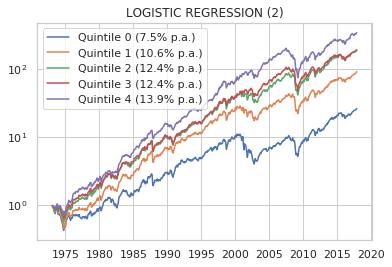

,Label,Annualized return,Annualized volatility,Sharpe
0,Quintile 0,7.55,19.79,0.08
1,Quintile 1,10.59,18.14,0.25
2,Quintile 2,12.43,17.45,0.36
3,Quintile 3,12.38,16.25,0.38
4,Quintile 4,13.88,16.60,0.46


In [92]:
reportdict = {'Label': [],
              'Annualized return' : [],
              'Annualized volatility' : [],
              'Sharpe': []}

for i in range(num_buckets):

    # get returns for this bucket
    T0 = data3.loc[data3["PREDRANK"]==i]
    # get returns for t+1
    # inner join, note some stocks will not have returns for t+1
    # corp action or possibly also excluded by mkt cap filter
    T1 = T0[["DATETIME1", "GVKEY"]].merge(data3, how='left',
                                          left_on=["DATETIME1", "GVKEY"], 
                                          right_on=["DATETIME", "GVKEY"])[["DATETIME", "GVKEY", "RET"]]
    T2 = T0[["DATETIME2", "GVKEY"]].merge(data3, how='left',
                                          left_on=["DATETIME2", "GVKEY"], 
                                          right_on=["DATETIME", "GVKEY"])[["DATETIME", "GVKEY", "RET"]]
    T2.sort_values(['DATETIME', 'GVKEY']).tail()
    
    G0 = T0[["DATETIME","RET"]].groupby("DATETIME").mean()
    G1 = T1[["DATETIME","RET"]].groupby("DATETIME").mean()
    G2 = T2[["DATETIME","RET"]].groupby("DATETIME").mean()
    G_all = pd.merge(G1,G2,on="DATETIME", how="outer", suffixes=["1", "2"])
    G_all = pd.merge(G_all,G0,on="DATETIME", how="outer") \
        .sort_values("DATETIME") \
        .reset_index() 
    # average returns by month
    G_all = G_all.fillna(value=0) # otherwise only 1/3 of portfolio at work 1st month + 2 NAs = NA
    G_all["RET"] = (G_all["RET"] + G_all["RET1"] + G_all["RET2"]) /3
    
    # compute cumulative return
    tempdf = pd.DataFrame(G_all[["DATETIME", "RET"]])

    tempdf["RET1P"] = 1 + tempdf["RET"]
    tempdf["CUMPERF"] = tempdf["RET1P"].cumprod()
    tempdf.reset_index(inplace=True)
    tempdf["RF"] = RF["RF"]

    lastval = list(tempdf["CUMPERF"])[-1]
    annret = (lastval**(12/len(tempdf))-1)*100
    vol = tempdf["CUMPERF"].pct_change().std() * np.sqrt(12) * 100

    reportdict['Label'].append("Quintile %d " % (i))
    reportdict['Annualized return'].append(annret)
    reportdict['Annualized volatility'].append(vol)
    tempdf_sharpe = tempdf.dropna()
    reportdict['Sharpe'].append(sharpe(tempdf_sharpe["RET"], tempdf_sharpe["RF"]))

    tempdf.set_index("DATETIME", inplace=True)
    plt.semilogy(tempdf['CUMPERF'], label="Quintile %d (%.1f%% p.a.)" % (i, annret));

plt.legend();
plt.title("LOGISTIC REGRESSION (2)")
plt.show()

with pd.option_context('display.float_format', lambda x: "%.2f" % x):
    display(pd.DataFrame(reportdict))
    

Accuracy: 0.205189


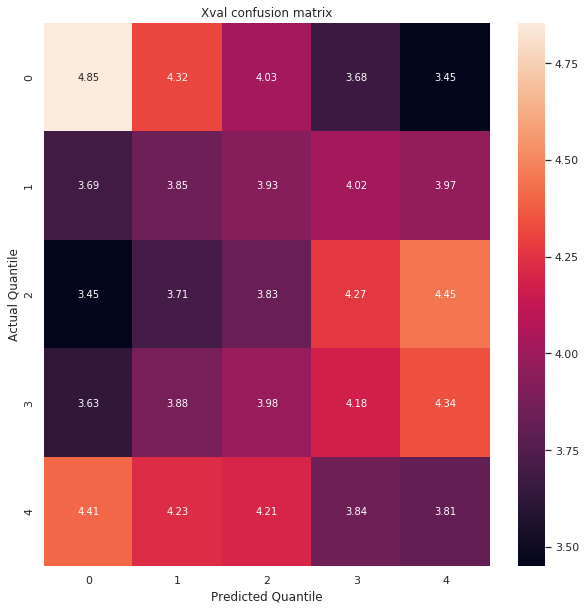

In [24]:
# prediction of RET3_RANK is PREDRANK
# compute accuracy, confusion_matrix

# expected value of n
ev_n = (len(data3)/25)
acc = accuracy_score(data3["RET3_RANK"], data3["PREDRANK"])
print ("Accuracy: %0.6f" % acc)

conf_matrix_heatmap(data3["RET3_RANK"], data3["PREDRANK"])

In [16]:
n_estimators = 300
max_depth = 14
subsample = 0.7
colsample_bytree = 1/3
learning_rate = 0.1
gamma = 0

for i in range(120, len(dateindexes)):
    
    daterange = dateindexes.index[0:i]
    print("fit from %s to %s" % (str(daterange[0]), str(daterange[-1])))
    fitrange = data2.iloc[0:dateindexes[i],:]
    print("fit from index %d to index %d" % (fitrange.iloc[0,:]["index"], fitrange.iloc[-1,:]["index"]))
    X = fitrange[["VALUE","MOMENTUM","FINANCIAL"]]
    y = fitrange["RET3_RANK"]
    
    model = xgboost.sklearn.XGBClassifier(n_estimators=n_estimators, 
                                        max_depth=max_depth, 
                                        subsample=subsample,
                                        min_child_weight=1,
                                        colsample_bytree=colsample_bytree,
                                        learning_rate=learning_rate,
                                        gamma=gamma,
                                        n_jobs=-1
                                       )
    model.fit(X, y)
    
    print("predict %s" % (dateindexes.index[i]))
    if i+1 >= len(dateindexes): # last start date, predict from there to the end
        predrange = data2.iloc[dateindexes[i]:,:]
    else:
        predrange = data2.iloc[dateindexes[i]:dateindexes[i+1],:]
    print("predict from index %d to index %d" % (predrange.iloc[0,:]["index"], predrange.iloc[-1,:]["index"]))
    X_predict = predrange[["VALUE","MOMENTUM","FINANCIAL"]]
    y_predict_proba = model.predict_proba(X_predict)
    # weighted average 
    y_predict = y_predict_proba.dot(np.matrix("0 ; 1; 2; 3; 4"))
    if i+1 >= len(dateindexes):
        P[dateindexes[i]:] = y_predict.reshape(y_predict.shape[0])
    else:
        P[dateindexes[i]:dateindexes[i+1]] = y_predict.reshape(y_predict.shape[0])

fit from 1963-01-31 00:00:00 to 1972-12-31 00:00:00
fit from index 0 to index 66483
predict 1973-01-31 00:00:00
predict from index 66484 to index 67220
fit from 1963-01-31 00:00:00 to 1973-01-31 00:00:00
fit from index 0 to index 67220
predict 1973-02-28 00:00:00
predict from index 67221 to index 67968
fit from 1963-01-31 00:00:00 to 1973-02-28 00:00:00
fit from index 0 to index 67968
predict 1973-03-31 00:00:00
predict from index 67969 to index 68694
fit from 1963-01-31 00:00:00 to 1973-03-31 00:00:00
fit from index 0 to index 68694
predict 1973-04-30 00:00:00
predict from index 68695 to index 69428
fit from 1963-01-31 00:00:00 to 1973-04-30 00:00:00
fit from index 0 to index 69428
predict 1973-05-31 00:00:00
predict from index 69429 to index 70168
fit from 1963-01-31 00:00:00 to 1973-05-31 00:00:00
fit from index 0 to index 70168
predict 1973-06-30 00:00:00
predict from index 70169 to index 70901
fit from 1963-01-31 00:00:00 to 1973-06-30 00:00:00
fit from index 0 to index 70901
pred

predict 1977-07-31 00:00:00
predict from index 110826 to index 111670
fit from 1963-01-31 00:00:00 to 1977-07-31 00:00:00
fit from index 0 to index 111670
predict 1977-08-31 00:00:00
predict from index 111671 to index 112507
fit from 1963-01-31 00:00:00 to 1977-08-31 00:00:00
fit from index 0 to index 112507
predict 1977-09-30 00:00:00
predict from index 112508 to index 113352
fit from 1963-01-31 00:00:00 to 1977-09-30 00:00:00
fit from index 0 to index 113352
predict 1977-10-31 00:00:00
predict from index 113353 to index 114206
fit from 1963-01-31 00:00:00 to 1977-10-31 00:00:00
fit from index 0 to index 114206
predict 1977-11-30 00:00:00
predict from index 114207 to index 115001
fit from 1963-01-31 00:00:00 to 1977-11-30 00:00:00
fit from index 0 to index 115001
predict 1977-12-31 00:00:00
predict from index 115002 to index 115821
fit from 1963-01-31 00:00:00 to 1977-12-31 00:00:00
fit from index 0 to index 115821
predict 1978-01-31 00:00:00
predict from index 115822 to index 116678


predict 1981-12-31 00:00:00
predict from index 154040 to index 154880
fit from 1963-01-31 00:00:00 to 1981-12-31 00:00:00
fit from index 0 to index 154880
predict 1982-01-31 00:00:00
predict from index 154881 to index 155739
fit from 1963-01-31 00:00:00 to 1982-01-31 00:00:00
fit from index 0 to index 155739
predict 1982-02-28 00:00:00
predict from index 155740 to index 156573
fit from 1963-01-31 00:00:00 to 1982-02-28 00:00:00
fit from index 0 to index 156573
predict 1982-03-31 00:00:00
predict from index 156574 to index 157385
fit from 1963-01-31 00:00:00 to 1982-03-31 00:00:00
fit from index 0 to index 157385
predict 1982-04-30 00:00:00
predict from index 157386 to index 158165
fit from 1963-01-31 00:00:00 to 1982-04-30 00:00:00
fit from index 0 to index 158165
predict 1982-05-31 00:00:00
predict from index 158166 to index 158986
fit from 1963-01-31 00:00:00 to 1982-05-31 00:00:00
fit from index 0 to index 158986
predict 1982-06-30 00:00:00
predict from index 158987 to index 159793


predict 1986-05-31 00:00:00
predict from index 196602 to index 197402
fit from 1963-01-31 00:00:00 to 1986-05-31 00:00:00
fit from index 0 to index 197402
predict 1986-06-30 00:00:00
predict from index 197403 to index 198236
fit from 1963-01-31 00:00:00 to 1986-06-30 00:00:00
fit from index 0 to index 198236
predict 1986-07-31 00:00:00
predict from index 198237 to index 199127
fit from 1963-01-31 00:00:00 to 1986-07-31 00:00:00
fit from index 0 to index 199127
predict 1986-08-31 00:00:00
predict from index 199128 to index 199938
fit from 1963-01-31 00:00:00 to 1986-08-31 00:00:00
fit from index 0 to index 199938
predict 1986-09-30 00:00:00
predict from index 199939 to index 200816
fit from 1963-01-31 00:00:00 to 1986-09-30 00:00:00
fit from index 0 to index 200816
predict 1986-10-31 00:00:00
predict from index 200817 to index 201650
fit from 1963-01-31 00:00:00 to 1986-10-31 00:00:00
fit from index 0 to index 201650
predict 1986-11-30 00:00:00
predict from index 201651 to index 202484


predict 1990-10-31 00:00:00
predict from index 240012 to index 240847
fit from 1963-01-31 00:00:00 to 1990-10-31 00:00:00
fit from index 0 to index 240847
predict 1990-11-30 00:00:00
predict from index 240848 to index 241637
fit from 1963-01-31 00:00:00 to 1990-11-30 00:00:00
fit from index 0 to index 241637
predict 1990-12-31 00:00:00
predict from index 241638 to index 242445
fit from 1963-01-31 00:00:00 to 1990-12-31 00:00:00
fit from index 0 to index 242445
predict 1991-01-31 00:00:00
predict from index 242446 to index 243257
fit from 1963-01-31 00:00:00 to 1991-01-31 00:00:00
fit from index 0 to index 243257
predict 1991-02-28 00:00:00
predict from index 243258 to index 244051
fit from 1963-01-31 00:00:00 to 1991-02-28 00:00:00
fit from index 0 to index 244051
predict 1991-03-31 00:00:00
predict from index 244052 to index 244874
fit from 1963-01-31 00:00:00 to 1991-03-31 00:00:00
fit from index 0 to index 244874
predict 1991-04-30 00:00:00
predict from index 244875 to index 245712


predict 1995-03-31 00:00:00
predict from index 288909 to index 289965
fit from 1963-01-31 00:00:00 to 1995-03-31 00:00:00
fit from index 0 to index 289965
predict 1995-04-30 00:00:00
predict from index 289966 to index 291052
fit from 1963-01-31 00:00:00 to 1995-04-30 00:00:00
fit from index 0 to index 291052
predict 1995-05-31 00:00:00
predict from index 291053 to index 292122
fit from 1963-01-31 00:00:00 to 1995-05-31 00:00:00
fit from index 0 to index 292122
predict 1995-06-30 00:00:00
predict from index 292123 to index 293184
fit from 1963-01-31 00:00:00 to 1995-06-30 00:00:00
fit from index 0 to index 293184
predict 1995-07-31 00:00:00
predict from index 293185 to index 294261
fit from 1963-01-31 00:00:00 to 1995-07-31 00:00:00
fit from index 0 to index 294261
predict 1995-08-31 00:00:00
predict from index 294262 to index 295361
fit from 1963-01-31 00:00:00 to 1995-08-31 00:00:00
fit from index 0 to index 295361
predict 1995-09-30 00:00:00
predict from index 295362 to index 296467


predict 1999-10-31 00:00:00
predict from index 354029 to index 355288
fit from 1963-01-31 00:00:00 to 1999-10-31 00:00:00
fit from index 0 to index 355288
predict 1999-12-31 00:00:00
predict from index 356524 to index 357781
fit from 1963-01-31 00:00:00 to 1999-12-31 00:00:00
fit from index 0 to index 357781
predict 2000-01-31 00:00:00
predict from index 357782 to index 359099
fit from 1963-01-31 00:00:00 to 2000-01-31 00:00:00
fit from index 0 to index 359099
predict 2000-02-29 00:00:00
predict from index 359100 to index 360422
fit from 1963-01-31 00:00:00 to 2000-02-29 00:00:00
fit from index 0 to index 360422
predict 2000-03-31 00:00:00
predict from index 360423 to index 361674
fit from 1963-01-31 00:00:00 to 2000-03-31 00:00:00
fit from index 0 to index 361674
predict 2000-04-30 00:00:00
predict from index 361675 to index 362900
fit from 1963-01-31 00:00:00 to 2000-04-30 00:00:00
fit from index 0 to index 362900
predict 2000-05-31 00:00:00
predict from index 362901 to index 364121


predict 2004-04-30 00:00:00
predict from index 413658 to index 414691
fit from 1963-01-31 00:00:00 to 2004-04-30 00:00:00
fit from index 0 to index 414691
predict 2004-05-31 00:00:00
predict from index 414692 to index 415697
fit from 1963-01-31 00:00:00 to 2004-05-31 00:00:00
fit from index 0 to index 415697
predict 2004-06-30 00:00:00
predict from index 415698 to index 416675
fit from 1963-01-31 00:00:00 to 2004-06-30 00:00:00
fit from index 0 to index 416675
predict 2004-08-31 00:00:00
predict from index 417733 to index 418737
fit from 1963-01-31 00:00:00 to 2004-08-31 00:00:00
fit from index 0 to index 418737
predict 2004-09-30 00:00:00
predict from index 418738 to index 419718
fit from 1963-01-31 00:00:00 to 2004-09-30 00:00:00
fit from index 0 to index 419718
predict 2004-10-31 00:00:00
predict from index 419719 to index 420704
fit from 1963-01-31 00:00:00 to 2004-10-31 00:00:00
fit from index 0 to index 420704
predict 2004-11-30 00:00:00
predict from index 420705 to index 421647


predict 2008-12-31 00:00:00
predict from index 468395 to index 469341
fit from 1963-01-31 00:00:00 to 2008-12-31 00:00:00
fit from index 0 to index 469341
predict 2009-01-31 00:00:00
predict from index 469342 to index 470363
fit from 1963-01-31 00:00:00 to 2009-01-31 00:00:00
fit from index 0 to index 470363
predict 2009-02-28 00:00:00
predict from index 470364 to index 471396
fit from 1963-01-31 00:00:00 to 2009-02-28 00:00:00
fit from index 0 to index 471396
predict 2009-03-31 00:00:00
predict from index 471397 to index 472318
fit from 1963-01-31 00:00:00 to 2009-03-31 00:00:00
fit from index 0 to index 472318
predict 2009-04-30 00:00:00
predict from index 472319 to index 473163
fit from 1963-01-31 00:00:00 to 2009-04-30 00:00:00
fit from index 0 to index 473163
predict 2009-05-31 00:00:00
predict from index 473164 to index 474079
fit from 1963-01-31 00:00:00 to 2009-05-31 00:00:00
fit from index 0 to index 474079
predict 2009-06-30 00:00:00
predict from index 474080 to index 475042


predict 2013-05-31 00:00:00
predict from index 519207 to index 520153
fit from 1963-01-31 00:00:00 to 2013-05-31 00:00:00
fit from index 0 to index 520153
predict 2013-06-30 00:00:00
predict from index 520154 to index 521153
fit from 1963-01-31 00:00:00 to 2013-06-30 00:00:00
fit from index 0 to index 521153
predict 2013-07-31 00:00:00
predict from index 521154 to index 522094
fit from 1963-01-31 00:00:00 to 2013-07-31 00:00:00
fit from index 0 to index 522094
predict 2013-08-31 00:00:00
predict from index 522095 to index 523102
fit from 1963-01-31 00:00:00 to 2013-08-31 00:00:00
fit from index 0 to index 523102
predict 2013-09-30 00:00:00
predict from index 523103 to index 524077
fit from 1963-01-31 00:00:00 to 2013-09-30 00:00:00
fit from index 0 to index 524077
predict 2013-10-31 00:00:00
predict from index 524078 to index 525048
fit from 1963-01-31 00:00:00 to 2013-10-31 00:00:00
fit from index 0 to index 525048
predict 2013-11-30 00:00:00
predict from index 525049 to index 526022


In [17]:
# we now have forecasts for full period
# bucket forecasts

# put P forecast into data2
data2["P"] = P  

# bucket predictions, put into PREDRANK
data3 = None
for d in dateindexes.index[120:]:
    tempdf = data2.loc[data2["DATETIME"]==d]
    print(d, len(tempdf))
    tempdf["PREDRANK"] = pd.qcut(tempdf["P"], num_buckets, labels=False)
    if data3 is None:
        data3 = tempdf
    else:
        data3 = pd.concat([data3, tempdf])

1973-01-31 00:00:00 737
1973-02-28 00:00:00 748
1973-03-31 00:00:00 726
1973-04-30 00:00:00 734
1973-05-31 00:00:00 740
1973-06-30 00:00:00 733
1973-07-31 00:00:00 687
1973-08-31 00:00:00 732
1973-09-30 00:00:00 685
1973-10-31 00:00:00 735
1973-11-30 00:00:00 808
1973-12-31 00:00:00 732
1974-01-31 00:00:00 839
1974-02-28 00:00:00 862
1974-03-31 00:00:00 873
1974-04-30 00:00:00 909
1974-05-31 00:00:00 902
1974-06-30 00:00:00 891
1974-07-31 00:00:00 901
1974-08-31 00:00:00 920
1974-09-30 00:00:00 919
1974-10-31 00:00:00 819
1974-11-30 00:00:00 900
1974-12-31 00:00:00 894
1975-01-31 00:00:00 756
1975-02-28 00:00:00 837
1975-03-31 00:00:00 821
1975-04-30 00:00:00 835
1975-05-31 00:00:00 826
1975-06-30 00:00:00 809
1975-07-31 00:00:00 873
1975-08-31 00:00:00 861
1975-09-30 00:00:00 866
1975-10-31 00:00:00 840
1975-11-30 00:00:00 829
1975-12-31 00:00:00 846
1976-01-31 00:00:00 779
1976-02-29 00:00:00 823
1976-03-31 00:00:00 833
1976-04-30 00:00:00 842
1976-05-31 00:00:00 849
1976-06-30 00:00

2001-10-31 00:00:00 1020
2001-11-30 00:00:00 1018
2001-12-31 00:00:00 1053
2002-01-31 00:00:00 1097
2002-02-28 00:00:00 1047
2002-03-31 00:00:00 997
2002-04-30 00:00:00 1027
2002-05-31 00:00:00 1038
2002-06-30 00:00:00 1047
2002-07-31 00:00:00 1095
2002-08-31 00:00:00 1005
2002-09-30 00:00:00 1081
2002-10-31 00:00:00 992
2002-11-30 00:00:00 982
2002-12-31 00:00:00 1052
2003-01-31 00:00:00 1035
2003-02-28 00:00:00 1039
2003-03-31 00:00:00 1016
2003-04-30 00:00:00 964
2003-05-31 00:00:00 978
2003-06-30 00:00:00 1013
2003-07-31 00:00:00 1005
2003-08-31 00:00:00 1015
2003-09-30 00:00:00 1026
2003-10-31 00:00:00 989
2003-11-30 00:00:00 1022
2003-12-31 00:00:00 1009
2004-01-31 00:00:00 1018
2004-02-29 00:00:00 1015
2004-03-31 00:00:00 1025
2004-04-30 00:00:00 1034
2004-05-31 00:00:00 1006
2004-06-30 00:00:00 978
2004-07-31 00:00:00 1057
2004-08-31 00:00:00 1005
2004-09-30 00:00:00 981
2004-10-31 00:00:00 986
2004-11-30 00:00:00 943
2004-12-31 00:00:00 990
2005-01-31 00:00:00 1033
2005-02-28 

In [20]:
data3.to_pickle('classification_predict_buckets.pickle')
data3.head()


,index,DATETIME,GVKEY,FINANCIAL,VALUE,MOMENTUM,RET,RET3_RANK,RET3,P,PREDRANK
66484,66484,1973-01-31,1010,0,1.044125,-0.010382,-0.060367,1,-0.035879,1.892025,2
66485,66485,1973-01-31,1040,0,0.215630,0.147918,-0.336343,0,-0.426136,1.928456,2
66486,66486,1973-01-31,1043,0,0.600845,0.125996,-0.166667,0,-0.381818,1.575955,0
66487,66487,1973-01-31,1045,0,0.835086,-0.331288,-0.223881,0,-0.194030,2.218436,4
66488,66488,1973-01-31,1075,0,1.047037,0.246193,-0.040000,0,-0.129671,2.045420,3


In [93]:
# we predicted 3-month returns
# for all the 1s, we will collect this month's return + next 2 months, to hold for 3 months [datetime, gvkey, return, monthno]

# for now, store the DATES values as extra columns in data3
data3=pd.read_pickle('classification_predict_buckets.pickle')
# create dataframe of all the dates
dates_df = pd.DataFrame(dateindexes)
dates_df["t0"]=dates_df.index
dates_df["t1"]=dates_df.shift(-1)["t0"]
dates_df["t2"]=dates_df.shift(-2)["t0"]

In [94]:
dates_df.head()

,index,t0,t1,t2
DATETIME,,,,
1963-01-31,0,1963-01-31,1963-02-28,1963-03-31
1963-02-28,402,1963-02-28,1963-03-31,1963-04-30
1963-03-31,818,1963-03-31,1963-04-30,1963-05-31
1963-04-30,1228,1963-04-30,1963-05-31,1963-06-30
1963-05-31,1637,1963-05-31,1963-06-30,1963-07-31


In [95]:
# store t+1 and t+2 in data3
data3["DATETIME1"] = dates_df.loc[data3["DATETIME"]]["t1"].values
data3["DATETIME2"] = dates_df.loc[data3["DATETIME"]]["t2"].values

In [96]:
display(data3.head())
display(data3.tail())

,index,DATETIME,GVKEY,FINANCIAL,VALUE,MOMENTUM,RET,RET3_RANK,RET3,P,PREDRANK,DATETIME1,DATETIME2
66484,66484,1973-01-31,1010,0,1.044125,-0.010382,-0.060367,1,-0.035879,1.892025,2,1973-02-28,1973-03-31
66485,66485,1973-01-31,1040,0,0.215630,0.147918,-0.336343,0,-0.426136,1.928456,2,1973-02-28,1973-03-31
66486,66486,1973-01-31,1043,0,0.600845,0.125996,-0.166667,0,-0.381818,1.575955,0,1973-02-28,1973-03-31
66487,66487,1973-01-31,1045,0,0.835086,-0.331288,-0.223881,0,-0.194030,2.218436,4,1973-02-28,1973-03-31
66488,66488,1973-01-31,1075,0,1.047037,0.246193,-0.040000,0,-0.129671,2.045420,3,1973-02-28,1973-03-31


,index,DATETIME,GVKEY,FINANCIAL,VALUE,MOMENTUM,RET,RET3_RANK,RET3,P,PREDRANK,DATETIME1,DATETIME2
574585,574585,2017-10-31,293884,0,0.181239,0.431529,0.048302,4,0.157079,2.074484,3,NaT,NaT
574586,574586,2017-10-31,294524,0,0.246494,0.156449,0.045230,3,0.122867,2.155224,4,NaT,NaT
574587,574587,2017-10-31,295786,0,0.291927,0.590161,0.057452,3,0.115736,2.017998,2,NaT,NaT
574588,574588,2017-10-31,315318,0,0.936775,0.440197,-0.040359,0,-0.110314,1.890872,0,NaT,NaT
574589,574589,2017-10-31,316056,1,0.014658,0.149037,-0.035619,1,-0.078062,1.972795,1,NaT,NaT


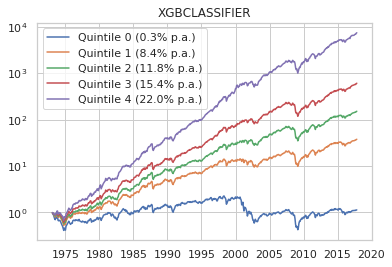

,Label,Annualized return,Annualized volatility,Sharpe
0,Quintile 0,0.28,20.36,-0.26
1,Quintile 1,8.43,16.97,0.14
2,Quintile 2,11.84,16.19,0.35
3,Quintile 3,15.37,16.06,0.56
4,Quintile 4,21.99,17.58,0.87


In [97]:
# compute returns by bucket
# calculate sharpe

reportdict = {'Label': [],
              'Annualized return' : [],
              'Annualized volatility' : [],
              'Sharpe': []}

for i in range(num_buckets):

    # get returns for this bucket
    T0 = data3.loc[data3["PREDRANK"]==i]
    # get returns for t+1
    # inner join, note some stocks will not have returns for t+1
    # corp action or possibly also excluded by mkt cap filter
    T1 = T0[["DATETIME1", "GVKEY"]].merge(data3, how='left',
                                          left_on=["DATETIME1", "GVKEY"], 
                                          right_on=["DATETIME", "GVKEY"])[["DATETIME", "GVKEY", "RET"]]
    T2 = T0[["DATETIME2", "GVKEY"]].merge(data3, how='left',
                                          left_on=["DATETIME2", "GVKEY"], 
                                          right_on=["DATETIME", "GVKEY"])[["DATETIME", "GVKEY", "RET"]]
    T2.sort_values(['DATETIME', 'GVKEY']).tail()
    
    G0 = T0[["DATETIME","RET"]].groupby("DATETIME").mean()
    G1 = T1[["DATETIME","RET"]].groupby("DATETIME").mean()
    G2 = T2[["DATETIME","RET"]].groupby("DATETIME").mean()
    G_all = pd.merge(G1,G2,on="DATETIME", how="outer", suffixes=["1", "2"])
    G_all = pd.merge(G_all,G0,on="DATETIME", how="outer") \
        .sort_values("DATETIME") \
        .reset_index() 
    # average returns by month
    G_all = G_all.fillna(value=0) # otherwise only 1/3 of portfolio at work 1st month + 2 NAs = NA
    G_all["RET"] = (G_all["RET"] + G_all["RET1"] + G_all["RET2"]) /3
    
    # compute cumulative return
    tempdf = pd.DataFrame(G_all[["DATETIME", "RET"]])

    tempdf["RET1P"] = 1 + tempdf["RET"]
    tempdf["CUMPERF"] = tempdf["RET1P"].cumprod()
    tempdf.reset_index(inplace=True)
    tempdf["RF"] = RF["RF"]

    lastval = list(tempdf["CUMPERF"])[-1]
    annret = (lastval**(12/len(tempdf))-1)*100
    vol = tempdf["CUMPERF"].pct_change().std() * np.sqrt(12) * 100

    reportdict['Label'].append("Quintile %d " % (i))
    reportdict['Annualized return'].append(annret)
    reportdict['Annualized volatility'].append(vol)
    tempdf_sharpe = tempdf.dropna()
    reportdict['Sharpe'].append(sharpe(tempdf_sharpe["RET"], tempdf_sharpe["RF"]))

    tempdf.set_index("DATETIME", inplace=True)
    plt.semilogy(tempdf['CUMPERF'], label="Quintile %d (%.1f%% p.a.)" % (i, annret));

plt.legend();
plt.title("XGBCLASSIFIER")
plt.show()

with pd.option_context('display.float_format', lambda x: "%.2f" % x):
    display(pd.DataFrame(reportdict))
    

In [91]:
data3.describe()

,index,GVKEY,FINANCIAL,VALUE,MOMENTUM,RET,RET3_RANK,RET3,P,PREDRANK
count,508106.000000,508106.000000,508106.000000,508106.000000,508106.000000,508106.000000,508106.000000,508106.000000,508106.000000,508106.000000
mean,320536.500000,22776.528856,0.167215,0.607723,0.194926,0.008562,2.008959,0.030434,1.962230,1.999610
std,146677.712275,40034.714874,0.373168,0.477683,0.431271,0.104942,1.423827,0.183504,0.223641,1.414947
min,66484.000000,1004.000000,0.000000,-0.942157,-0.989569,-0.981295,0.000000,-0.997347,0.111752,0.000000
25%,193510.250000,4809.000000,0.000000,0.270813,-0.046494,-0.044631,1.000000,-0.065777,1.861227,1.000000
50%,320536.500000,8539.000000,0.000000,0.487433,0.136251,0.008130,2.000000,0.028677,1.973470,2.000000
75%,447562.750000,14650.000000,0.000000,0.838238,0.349474,0.060986,3.000000,0.123167,2.071484,3.000000
max,574589.000000,316056.000000,1.000000,3.996615,4.000000,3.001658,4.000000,5.131941,3.838880,4.000000


Accuracy: 0.230066


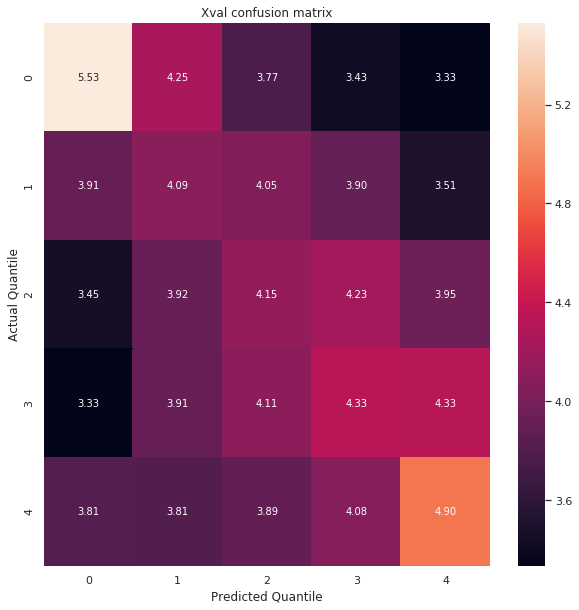

In [100]:
# prediction of RET3_RANK is PREDRANK
# compute accuracy, confusion_matrix

# expected value of n
ev_n = (len(data3)/25)
acc = accuracy_score(data3["RET3_RANK"], data3["PREDRANK"])
print ("Accuracy: %0.6f" % acc)

conf_matrix_heatmap(data3["RET3_RANK"], data3["PREDRANK"])

In [ ]:
# plot feature importances
import operator

featimpdict = backtestmodel.model._Booster.get_score(importance_type='gain')

xgb_featlabels=[]
xgb_featimps = []

for key, val in reversed(sorted(featimpdict.items(), key=operator.itemgetter(1))):
    xgb_featlabels.append(key)
    xgb_featimps.append(val)

def plotly_feat_imp(labels, featimps, name):

    trace1 = Bar(
        x=labels[:30],
        y=featimps[:30],
        name=name,
    )

    zlayout = Layout(
        title='%s Feature Importance' % (name),        
        xaxis = dict(title = "", 
                     tickangle=30,
                     tickfont=dict(
                         size=10,
                         color='black'
                     )),
        yaxis = dict(title = "Importance", 
                    ),
        
        margin=layout.Margin(
            b=150,
        ),    
        barmode='group',
    )

    data = [trace1]
    
    fig = Figure(data=data, layout=zlayout)
    iplot(fig)

plotly_feat_imp(xgb_featlabels, xgb_featimps, "XGBoost")